## Key findings: 
- Data where 'b_in_kontakt_gewesen' = 1 should be used for training.
- The label is 'b_gekauft_gesamt'
- This is a binary classification problem
- With a good model from training, we could predict for data where 'b_in_kontakt_gewesen' = 0 whether or not contacting the customer would lead a customer to buy and thereby change 'b_gekauft_gesamt' from 0 to 1.
  
- The training data set is very small: 95 rows with 57 rows for label = 1 and 38 rows for label = 0
- The classifiers tested here almost never surpassed 60% accuracy.
- This means we are essentially in the area of random guessing the solution in a binary classification problem.
- The results vary with every split of the data in test and validation data, because the dataset is so small.

- Out of Logistic Regression, KNeighbors, Support Vector Machine, Naive Baies and Random Forest as Classifier, Random Forest performed best.
- This was not only measured using accuracy, but also recall and  f1-score. 
- Therefore, Parameter tuning was also performed for Random Forest. However, the model still only reached a max accuracy of 0.66
- Simple Neural Networks were not tested here because the Dataset is simply to small to use a Neural Network Classifier on it.
- Another method that could be tested would be a Principal Component analysis on the continuous variables of the dataset.
- In general, more data should be collected for training. Then a good predictor could be set up with this data. 


In [126]:
# Import required packages and print versions

from platform import python_version
import random
import math
import uuid
import numpy as np
import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt
import pandas as pd
import sklearn

from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.metrics import accuracy_score, classification_report
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import StandardScaler

from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier
from sklearn import svm

from sklearn.feature_selection import SelectFromModel
from sklearn.feature_selection import RFE
from sklearn.model_selection import GridSearchCV 
from sklearn.model_selection import RandomizedSearchCV 

print('using:')
print('pandas version', pd.__version__)
print('matplotlib version', matplotlib.__version__)
print('seaborn version', sns.__version__)
print('sklearn_version', sklearn.__version__)
print('python_version', python_version())

using:
pandas version 2.0.3
matplotlib version 3.7.2
seaborn version 0.12.2
sklearn_version 1.3.0
python_version 3.11.5


In [127]:
class DataProcessor:
    def __init__(self, file_path):
        # read data from csv file
        self.df = pd.read_csv(file_path, header=0, index_col=0)
        print('\nDATA IMPORT:')
        self.df.head()
   
    def clean_data(self):
        # Remove duplicates
        self.df = self.df.drop_duplicates()

        # Convert 'q_OpeningHours' to float; change wrong value to NaN
        self.df['q_OpeningHours'] = pd.to_numeric(self.df['q_OpeningHours'], errors='coerce')
        

    def find_low_variance_cols(self):
        # Set a threshold for low variance
        threshold = 0.03
        variance = self.df.var()
        
        # Filter columns with variance below the threshold
        low_variance_columns = variance[variance < threshold]
        
        return low_variance_columns.index.tolist()

    def find_high_correlation_rows(self):        
        # Get correlation matrix
        correlation_matrix = self.df.corr().abs()
        avg_corr = correlation_matrix.mean(axis = 1)
        vals = correlation_matrix.where(np.triu(np.ones(correlation_matrix.shape), k=1).astype(bool))
        
        cut = 0.8
        drop = list()
            
        for row in range(len(vals)-1):
            col_idx = row + 1
            for col in range (col_idx, len(vals)):
                if(correlation_matrix.iloc[row, col] > cut):
                    if(avg_corr.iloc[row] > avg_corr.iloc[col]): 
                        drop.append(row)
                    else: 
                        drop.append(col)
        
        drop_set = list(set(drop))
        dropcols_names = list(self.df.columns[[item for item in drop_set]])
        
        return(dropcols_names)
    
    def plot_correlation_heatmap(self):
        
        # Plot a heatmap of the correlation matrix for a given DataFrame.

        # Calculate correlation matrix
        correlation_matrix = self.df.corr()
    
        # Plot heatmap
        plt.figure(figsize=(12, 10))
        sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")
        plt.title("Correlation Matrix")
        plt.show()

    def remove_unwanted_attributes(self):
        # Columns to remove due to low variance
        columns_to_remove_low_variance = self.find_low_variance_cols()
        
        # Remove the cols needed for training data split and training label: 
        columns_to_remove_low_variance = [col for col in columns_to_remove_low_variance if col not in ['b_in_kontakt_gewesen', 'b_gekauft_gesamt']]
        print("\nColumns with low variance:")
        print(columns_to_remove_low_variance)
        
        columns_to_remove_correlation = self.find_high_correlation_rows()
        print("\nColumns to remove due to high correlation found automatcially (not applied):")
        print(columns_to_remove_correlation)

        # after several tests, I decided to select the columns to remove myself; they lead to better results in the classifiers
        columns_to_remove_correlation = [
            'q_OpeningDays', 
            'q_2017 Total Households', 
            'q_2017 HHs: 5th Quintile (68.759 and above)',
            'q_2017 Pop 15+/Edu: University, Fachhochschule',
            'q_2017 Personal Effects: Per Capita',
            'q_2017 Personal Care: Per Capita'
        ]
        
        print("\nColumns to remove due to high correlation defined by me (applied):")
        print(columns_to_remove_correlation)
        columns_to_remove = columns_to_remove_low_variance + columns_to_remove_correlation
        self.df = self.df.drop(columns=columns_to_remove)

    def split_data(self):
        """
        My understanding of which data is the training data: 
        Business Question: Does b_in_kontakt_gewesen = 1 lead to b_gekauft_gesamt = 1? 
        This means that we can train a model with all the entries where b_in_kontakt_gewesen = 1 with label to predict being b_gekauft_gesamt
        If we have a good model, predict for the rest of the data if getting in touch with the customer can lead to b_gekauft_gesamt = 1
        """
        df_cd_new = self.df[self.df['b_in_kontakt_gewesen'] == 0]
        df_cd_train = self.df[self.df['b_in_kontakt_gewesen'] == 1]

        df_cd_new = df_cd_new.drop(columns=['b_in_kontakt_gewesen'])
        df_cd_train = df_cd_train.drop(columns=['b_in_kontakt_gewesen'])
        print('\nBalance of classes in trainingsdataframe:\n', df_cd_train['b_gekauft_gesamt'].value_counts())

        X = df_cd_train.loc[:, df_cd_train.columns != 'b_gekauft_gesamt']
        y = df_cd_train.loc[:, df_cd_train.columns == 'b_gekauft_gesamt']

        return X, y
        
    def print_data(self):
        print('\n Current Dataframe:\n')
        self.df.info()

In [128]:
class TestClassifier:
    def __init__(self, X, y, X_train, X_test, y_train, y_test, model_name='logreg', use_scaler=True, save_report_as_csv=False):
        # set up a class to test the different binary classifiers that I identified as applicable to the data:
        self.X = X
        self.y = y
        self.X_train = X_train
        self.X_test = X_test
        self.y_train = y_train
        self.y_test = y_test 
        self.use_scaler = use_scaler # binary variable to decide whether to normalize the data or not
        self.save_report_as_csv = save_report_as_csv # binary variable to decide whether to save the classfication report as csv

        # model name is passed to the class and the model is initalized accordingly
        # depending on the model, some steps like
        self.model_name = model_name

        if self.model_name=='logreg':
            self.model = LogisticRegression()
            
            # use RFE to get the columns most relevant to the Logistic Regression model:
            rfe = RFE(self.model)
            rfe = rfe.fit(self.X_train, self.y_train)
            selected_feat = self.X_train.columns[rfe.support_].values.ravel()
            print('\ncols selected for logreg:', selected_feat)
            
            # select the columns in the dataframes for training and testing: 
            self.X_train = X_train[selected_feat]
            self.X_test = X_test[selected_feat]

        elif self.model_name=='knn':
            # Check different values of k to find the ones best suited
            best_k = self.find_best_k()
            self.model = KNeighborsClassifier(n_neighbors = best_k)
            
        elif self.model_name=='svm':
            # initialize support Vector machine with rbf; linear does not work well on this data
            self.model = svm.SVC(kernel='rbf')
            
        elif self.model_name=='nb':
            # initialize Gaussian Naive Bayes Classifier
            self.model = GaussianNB()
            
        elif self.model_name=='rf':
            # initialize random forest params with standard values: 
            n_estimators = 100
            max_leaf_nodes = None
            max_features = 'sqrt'
            max_depth = None
            
            # Use search models to find best hyper parameters for random forest
            param_grid = { 
                'n_estimators': [20, 30, 40, 50], 
                'max_features': ['sqrt', 'log2', None],  
                'max_depth': [3, 5, 6, 7, 9], 
                'max_leaf_nodes': [3, 5, 6, 7, 9] 
            } 

            # Between GridSearchCV and RandomizedSearchCV I chose the latter because it needs less to compute power
            
            # params_search = GridSearchCV(RandomForestClassifier(), param_grid=param_grid) 
            params_search = RandomizedSearchCV(RandomForestClassifier(), param_grid) 
            
            params_search.fit(X_train, y_train) 
            best_params = params_search.best_params_
            print(best_params) 
            
            # overwrite default parameters with the ones that we found in the search:
            if not best_params['n_estimators'] is None:
                n_estimators = best_params['n_estimators']
            if not best_params['max_leaf_nodes'] is None:
                max_leaf_nodes = best_params['max_leaf_nodes']            
            if not best_params['max_features'] is None:
                max_features = best_params['max_features']
            if not best_params['max_depth'] is None:
                max_depth = best_params['max_depth']            

            # use select from model to get the columns most relevant for random forests: 
            sel = SelectFromModel(RandomForestClassifier(
                n_estimators=n_estimators, max_leaf_nodes=max_leaf_nodes, max_features=max_features, max_depth=max_depth
            ))
            sel.fit(X_train, y_train)

            # initialize model
            self.model = RandomForestClassifier(
                n_estimators=n_estimators, max_leaf_nodes=max_leaf_nodes, max_features=max_features, max_depth=max_depth
            )
            # find most valuable columns in the dataset: 
            selected_feat= X_train.columns[(sel.get_support())].values.ravel()
            print('\ncols selected for random forest:', selected_feat)

            # select the columns in the dataframes for training and testing:
            self.X_train = X_train[selected_feat]
            self.X_test = X_test[selected_feat]

        # After initializing the model: perform training and evaluation steps for the model that was defined:
        if self.use_scaler:
            # Use scaler to standardize the values for possibly better results
            self.scaler = StandardScaler()
            self.X_train = self.scaler.fit_transform(X_train)
            self.X_test = self.scaler.transform(X_test)

        self.train(self.X_train, self.y_train)
        self.evaluate(self.X_test, self.y_test)

    def train(self, X_train, y_train):
        # train or fit model
        self.model.fit(X_train, y_train)
    
    def predict(self, X_test):
        # check model prediction 
        return self.model.predict(X_test)
    
    def evaluate(self, X_test, y_test):
        # evaluate the results and save as csv if wanted
        y_pred = self.predict(X_test)
        accuracy = accuracy_score(y_pred, y_test)
        target_names=['b_gekauft_gesamt 0', 'b_gekauft_gesamt 1']
        report = classification_report(y_test, y_pred, target_names=target_names, zero_division=np.nan)
        print("\nAccuracy for {} on test set: {:.2f}".format(self.model_name, accuracy))
        print("\nClassification Report:")
        print(report)
        if self.save_report_as_csv: 
            self.classification_report_csv(classification_report(y_test, y_pred, target_names=target_names, zero_division=0.0)) # set zero division to 0; no nan error

    def classification_report_csv(self, report):
        # save classification report as csv with uuid in the file name
        random_id = uuid.uuid4()  # Generate a random UUID
        
        # Convert UUID to string and construct the plot filename
        report_filename = f'classification_report_model__{self.model_name}__{random_id}.csv'
        
        report_data = []
        lines = report.split('\n')
        for line in lines[2:4]:
            row = {}
            row_data = line.split('      ')
            row['class'] = row_data[0]
            row['precision'] = float(row_data[1])
            row['recall'] = float(row_data[2])
            row['f1_score'] = float(row_data[3])
            row['support'] = float(row_data[4])
            report_data.append(row)
        dataframe = pd.DataFrame.from_dict(report_data)
        dataframe.to_csv(report_filename, index = False)


    def find_best_k(self, max_k=40):
        # Finds best number of neighbors for KNeighborsClassifier
        # loop thorugh range from 1 to max_k and return best value for k
        scores = []
        k_values = [i for i in range(1, max_k+1)]
        for k in k_values:
            knn = KNeighborsClassifier(n_neighbors=k)
            score = cross_val_score(knn, self.X, self.y, cv=5)
            mean_score = np.mean(score)
            if math.isnan(mean_score):
                mean_score = 0.0
            scores.append(np.mean(score))
    
        best_index = np.argmax(scores)
        best_k = k_values[best_index]
        print("Best K value:", best_k)
        return best_k


DATA IMPORT:


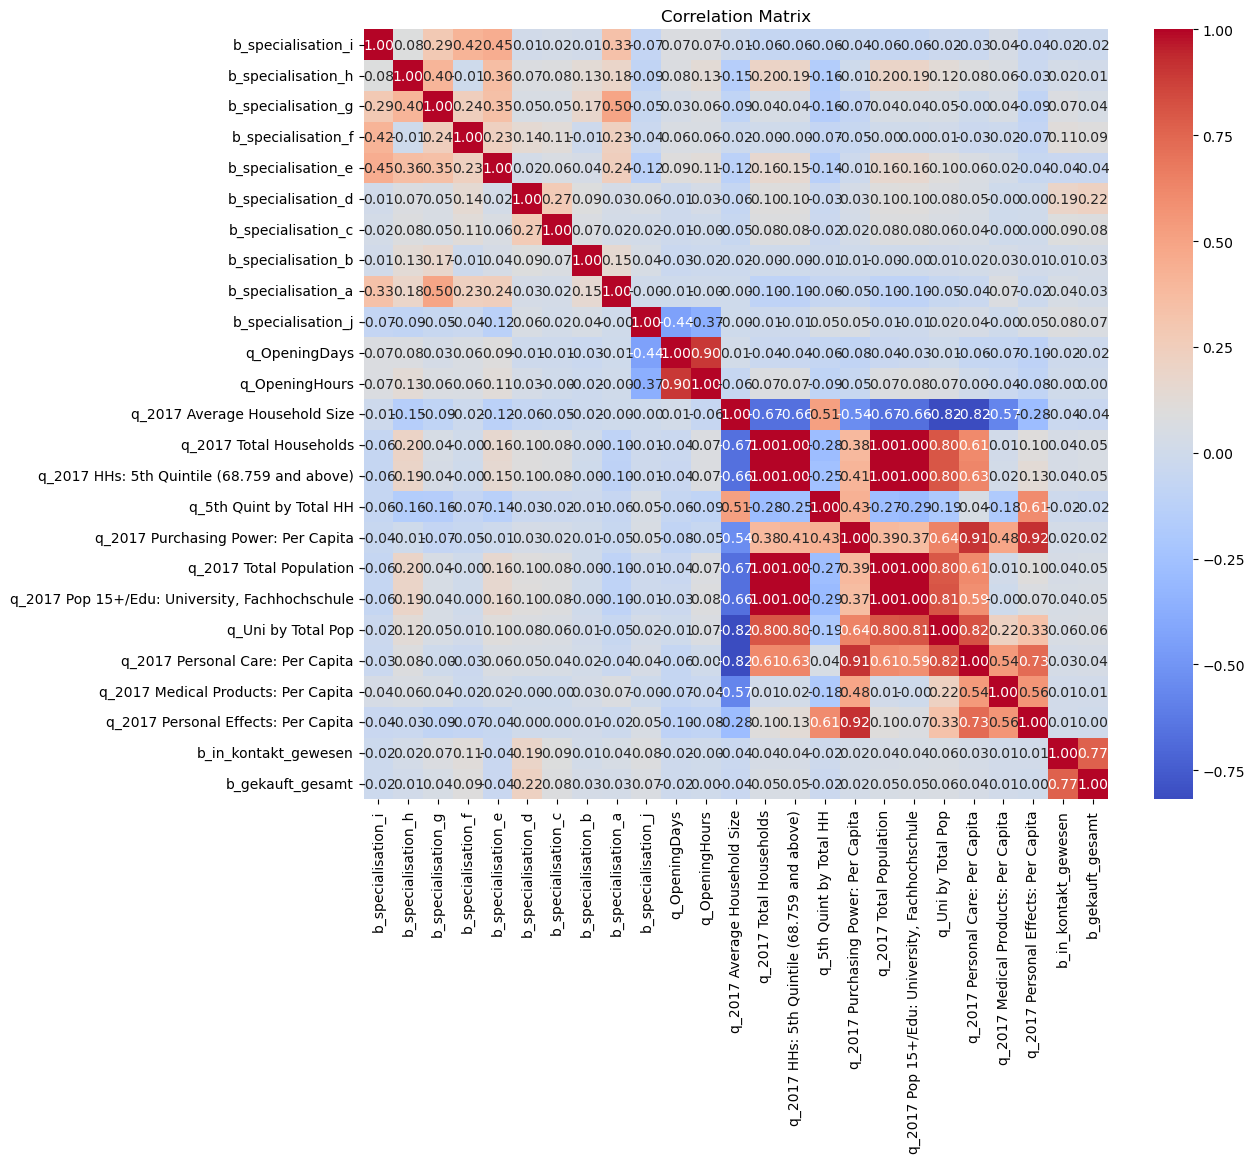


Columns with low variance:
['b_specialisation_d', 'b_specialisation_c', 'b_specialisation_b', 'q_2017 Average Household Size', 'q_5th Quint by Total HH', 'q_Uni by Total Pop']

Columns to remove due to high correlation found automatcially (not applied):
['q_OpeningHours', 'q_2017 Average Household Size', 'q_2017 Total Households', 'q_2017 HHs: 5th Quintile (68.759 and above)', 'q_2017 Purchasing Power: Per Capita', 'q_2017 Total Population', 'q_Uni by Total Pop', 'q_2017 Personal Care: Per Capita']

Columns to remove due to high correlation defined by me (applied):
['q_OpeningDays', 'q_2017 Total Households', 'q_2017 HHs: 5th Quintile (68.759 and above)', 'q_2017 Pop 15+/Edu: University, Fachhochschule', 'q_2017 Personal Effects: Per Capita', 'q_2017 Personal Care: Per Capita']

 Current Dataframe:

<class 'pandas.core.frame.DataFrame'>
Index: 3756 entries, 1069_7334 to 0_27
Data columns (total 13 columns):
 #   Column                               Non-Null Count  Dtype  
---  ------ 

In [129]:
# Initialize DataProcessor instance
data_processor = DataProcessor('CustomerData_LeadGenerator.csv')

# Clean the data (unique values, handle empty calues, cast columns if needed
data_processor.clean_data()

# check correlation heatmap to see which columns to remove due to high correlation: 
data_processor.plot_correlation_heatmap()

# Columns to remove due to high correlation
# I want to remove the columns that are highly correlated with others
# between q_OpeningDays and q_OpeningHours, I will choose q_OpeningHours (more detailed info in there)
# between q_2017 Total Households, q_2017 HHs: 5th Quintile (68.759 and above), q_2017 Total Population, and q_2017 Pop 15+/Edu: University, Fachhochschule: 
# I will only keep q_2017 Total Population, because it is the most generic attribute. 
# Also, the attribute 'q_2017 Average Household Size' was already removed due to low variance; so total population should be enough
# Choose one of 'q_2017 Purchasing Power: Per Capita', 'q_2017 Personal Care: Per Capita', 'q_2017 Personal Effects: Per Capita', 

data_processor.remove_unwanted_attributes()

data_processor.print_data()


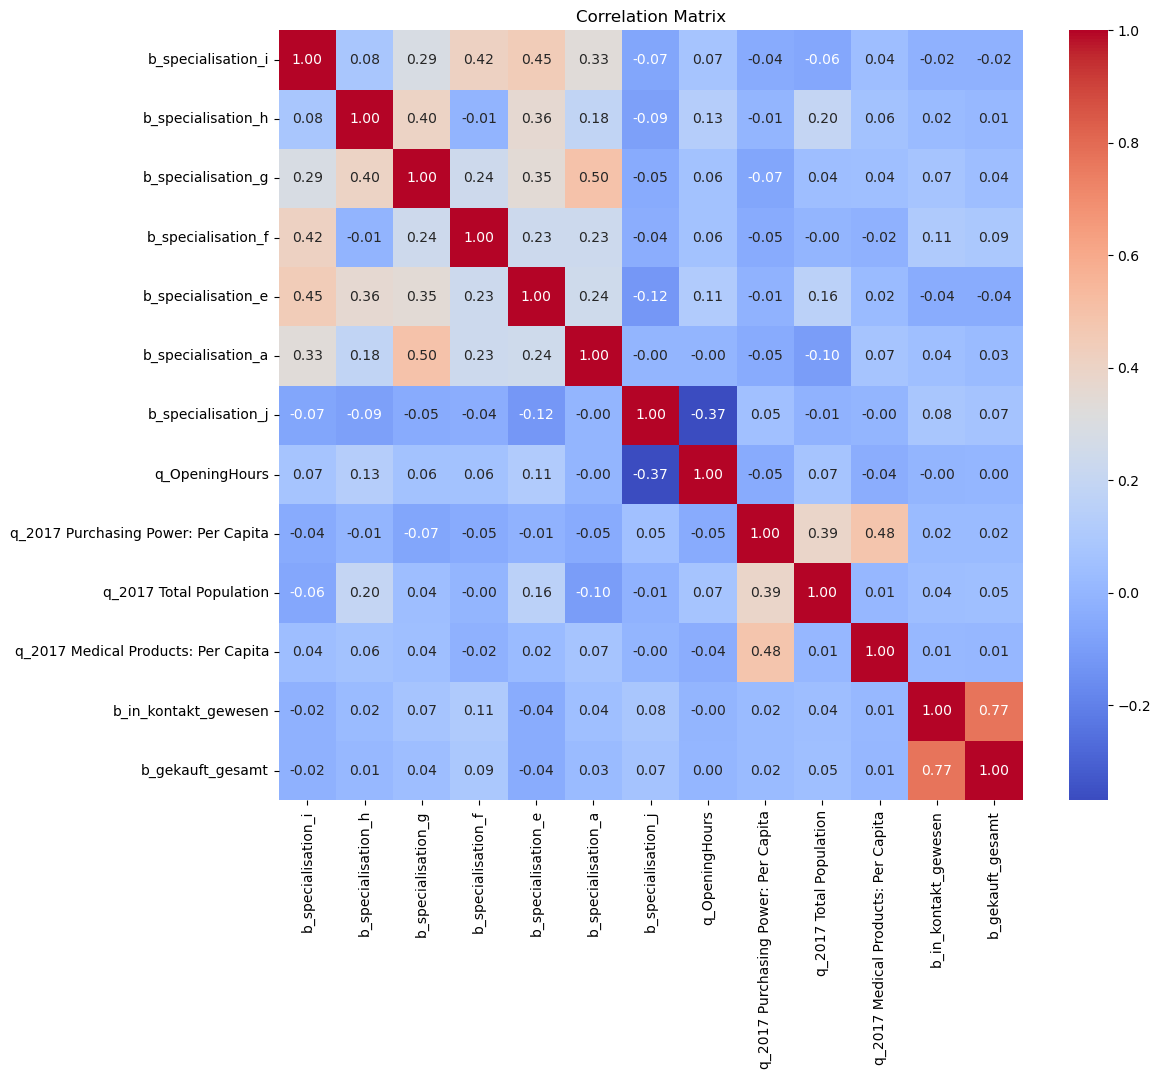


Balance of classes in trainingsdataframe:
 b_gekauft_gesamt
1    57
0    38
Name: count, dtype: int64

 Current Dataframe:

<class 'pandas.core.frame.DataFrame'>
Index: 3756 entries, 1069_7334 to 0_27
Data columns (total 13 columns):
 #   Column                               Non-Null Count  Dtype  
---  ------                               --------------  -----  
 0   b_specialisation_i                   3756 non-null   int64  
 1   b_specialisation_h                   3756 non-null   int64  
 2   b_specialisation_g                   3756 non-null   int64  
 3   b_specialisation_f                   3756 non-null   int64  
 4   b_specialisation_e                   3756 non-null   int64  
 5   b_specialisation_a                   3756 non-null   int64  
 6   b_specialisation_j                   3756 non-null   int64  
 7   q_OpeningHours                       3755 non-null   float64
 8   q_2017 Purchasing Power: Per Capita  3756 non-null   float64
 9   q_2017 Total Population           

In [130]:
# check correlation heatmap after data cleaning: 
data_processor.plot_correlation_heatmap()

# Split the data:
# My understanding of which data is the training data: 
# the goal has to be that b_gekauft_gesamt is true, meaning its value is 1
# the question I see: does b_in_kontakt_gewesen = 1 lead to b_gekauft_gesamt = 1? 
# where b_in_kontakt_gewesen = 0, b_gekauft_gesamt should also be = 0; 
# I checked this and b_gekauft_gesamt can only have value 1 if b_in_kontakt_gewesen has value 1
# this means that we can train a model with all the entries where b_in_kontakt_gewesen = 1 with label b_gekauft_gesamt
# and if we have a good model, predict for the rest of the data
# if getting in touch with the customer can lead to b_gekauft_gesamt = 1 and then predict for the rest of the data

# --> This is a binary classification problem. 

X, y = data_processor.split_data()

# After this step, we only have 95 rows left with 'b_in_kontakt_gewesen' = 1
# this is not a lot of data to to binary classification. 
# The classes, however, seem quite balanced (58 and 37 rows)
# The dataframe for training is very small
# and with this amount of data, syntetic datapoints to balance classes more also pose a risk. Therefore, I will leave the dataframe as is.
# in Real life, I would wait to set up the model until more datapoints become avaliable with time (as more customers in the list are contacted)

# Print cleaned data
data_processor.print_data()

# Split the data into test and training data
# the test_size seems to change the results of the classifiers a lot
# this is due to the small size of the training set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)
y = y.values.ravel()
y_train = y_train.values.ravel()
y_test = y_test.values.ravel()

# For the binary classification problem, we can try different standard classifiers
# These are suited for the amount of data we have

In [131]:
# TEST Logistic Regression Classifier
TestClassifier(X, y, X_train, X_test, y_train, y_test, 'logreg', save_report_as_csv=False)


cols selected for logreg: ['b_specialisation_e' 'q_OpeningHours'
 'q_2017 Purchasing Power: Per Capita' 'q_2017 Total Population'
 'q_2017 Medical Products: Per Capita']

Accuracy for logreg on test set: 0.46

Classification Report:
                    precision    recall  f1-score   support

b_gekauft_gesamt 0       0.43      0.25      0.32        12
b_gekauft_gesamt 1       0.47      0.67      0.55        12

          accuracy                           0.46        24
         macro avg       0.45      0.46      0.43        24
      weighted avg       0.45      0.46      0.43        24



In [132]:
# TEST KNeighbors Classifier
TestClassifier(X, y, X_train, X_test, y_train, y_test, 'knn', save_report_as_csv=False)

Best K value: 38

Accuracy for knn on test set: 0.50

Classification Report:
                    precision    recall  f1-score   support

b_gekauft_gesamt 0        nan      0.00       nan        12
b_gekauft_gesamt 1       0.50      1.00      0.67        12

          accuracy                           0.50        24
         macro avg       0.50      0.50      0.67        24
      weighted avg       0.50      0.50      0.67        24



/opt/conda/envs/anaconda-panel-2023.05-py310/lib/python3.11/site-packages/sklearn/model_selection/_validation.py:842: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/opt/conda/envs/anaconda-panel-2023.05-py310/lib/python3.11/site-packages/sklearn/metrics/_scorer.py", line 140, in __call__
    score = scorer(estimator, *args, **routed_params.get(name).score)
            ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/opt/conda/envs/anaconda-panel-2023.05-py310/lib/python3.11/site-packages/sklearn/metrics/_scorer.py", line 527, in __call__
    return estimator.score(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/opt/conda/envs/anaconda-panel-2023.05-py310/lib/python3.11/site-packages/sklearn/base.py", line 705, in score
    return accuracy_score(y, self.predict(X), sample_weight=sample_weight)
                             ^^^^^^^^^^^

In [133]:
# TEST Naive Baies Classifier
TestClassifier(X, y, X_train, X_test, y_train, y_test, 'nb', save_report_as_csv=False)


Accuracy for nb on test set: 0.33

Classification Report:
                    precision    recall  f1-score   support

b_gekauft_gesamt 0       0.17      0.08      0.11        12
b_gekauft_gesamt 1       0.39      0.58      0.47        12

          accuracy                           0.33        24
         macro avg       0.28      0.33      0.29        24
      weighted avg       0.28      0.33      0.29        24



In [134]:
# TEST Support Vector Machine Classifier
TestClassifier(X, y, X_train, X_test, y_train, y_test, 'svm', save_report_as_csv=False)


Accuracy for svm on test set: 0.46

Classification Report:
                    precision    recall  f1-score   support

b_gekauft_gesamt 0       0.33      0.08      0.13        12
b_gekauft_gesamt 1       0.48      0.83      0.61        12

          accuracy                           0.46        24
         macro avg       0.40      0.46      0.37        24
      weighted avg       0.40      0.46      0.37        24



In [135]:
# TEST Random Forest Classifier (this can take a while due to the parameter search)
TestClassifier(X, y, X_train, X_test, y_train, y_test, 'rf', use_scaler=False, save_report_as_csv=False)

{'n_estimators': 20, 'max_leaf_nodes': 7, 'max_features': 'log2', 'max_depth': 3}

cols selected for random forest: ['q_OpeningHours' 'q_2017 Purchasing Power: Per Capita'
 'q_2017 Total Population' 'q_2017 Medical Products: Per Capita']

Accuracy for rf on test set: 0.58

Classification Report:
                    precision    recall  f1-score   support

b_gekauft_gesamt 0       0.60      0.50      0.55        12
b_gekauft_gesamt 1       0.57      0.67      0.62        12

          accuracy                           0.58        24
         macro avg       0.59      0.58      0.58        24
      weighted avg       0.59      0.58      0.58        24

